In [1]:
%load_ext autoreload

In [2]:
from data_filtering import * 
from data_mod import *
from analysis import * 
from filters import *
from text_analysis import *

%autoreload 2
%reload_ext autoreload

In [3]:
import pandas as pd 
import numpy as np
from os import listdir
from os.path import isfile, join
import pickle
from collections import Counter
from functools import reduce


import re
import feather

import preprocessor as p

from tqdm import tqdm
from datetime import datetime

import nltk
import string
stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams.update({'font.size': 13})


plt.style.use('seaborn-white')
# sns.set_style("whitegrid")
# sns.set_style("darkgrid")

from IPython.display import display, HTML
# display(HTML(df2.to_html()))

# pd.set_option('display.max_colwidth', -1)


In [4]:
RAWDATA_DIR = join("data", "raw", "")
CLEANDATA_DIR = join("data", "clean", "") 
TEXTID_DIR = join("tweetids", "") 
MISSING_ID_DIR = join("data", "missing_data", "") 
RESULTS_DIR = join("output", "")

FILTER_DIR = join("results", "filtered_data", "")
INTENSITY_DIR = join("results", "intensity_data", "")
SENTIMENT_DIR = join("results", "sentiment_data", "")

In [5]:
def merge_dfs(df_list):
    return reduce(lambda left,right: pd.merge(left,right,on=['date_EST'], how='left'), df_list)

def get_col_name(listcolnames):
    newlist = ['date_EST']
    for i in listcolnames:
        newlist.append(i + '_all_tweets')
        newlist.append(i + '_original')
        newlist.append(i + '_retweet')
    return newlist

def get_comparison_plot(df_intensity, df_sentiment, plot_name):
    comparing_intensity_plots(df_intensity, 'date_EST', 'all_tweets', plot_name)
    sentiment_comparing_plots(df_sentiment, 'date_EST', plot_name)

In [6]:
def get_shape(df_list):
    for idx, df in enumerate(df_list):
        print(idx, df.shape)

df_cdc.shape:  (36159, 28)
retweet     23639
reply        6781
original     4921
quote         818
Name: tweet_type, dtype: int64


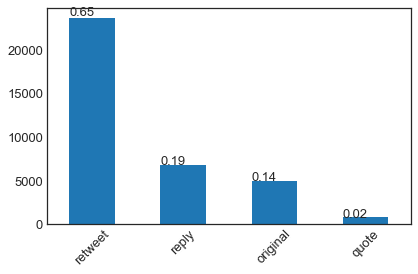

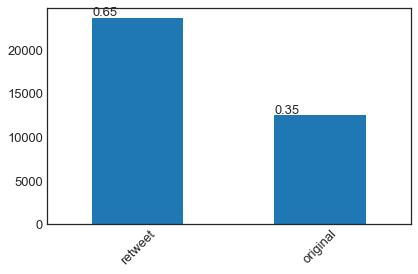

In [7]:
df_cdc = pd.read_csv(FILTER_DIR + "cdc_mask.csv")
print("df_cdc.shape: ", df_cdc.shape)
print(df_cdc.tweet_type.value_counts())

ax = df_cdc.tweet_type.value_counts().plot(kind='bar', rot=45)
for p in ax.patches:
    ax.annotate(str(round(p.get_height()/df_cdc.shape[0], 2)), (p.get_x() * 1, p.get_height() * 1.01))
plt.tight_layout()
plt.show()

ax = df_cdc.tweet_type_2.value_counts().plot(kind='bar', rot=45)
for p in ax.patches:
    ax.annotate(str(round(p.get_height()/df_cdc.shape[0], 2)), (p.get_x() * 1, p.get_height() * 1.01))
plt.tight_layout()
plt.show()

## Load Data

In [7]:
df_cdc = pd.read_csv(FILTER_DIR + "cdc_mask.csv")
print("df_cdc.shape: ", df_cdc.shape)

df_cdc.shape:  (36168, 28)


In [8]:
df_cdc.tweet_type.value_counts()

retweet     23639
reply        6783
original     4926
quote         820
Name: tweet_type, dtype: int64

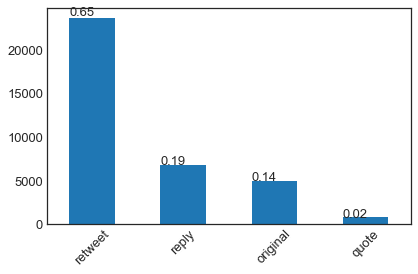

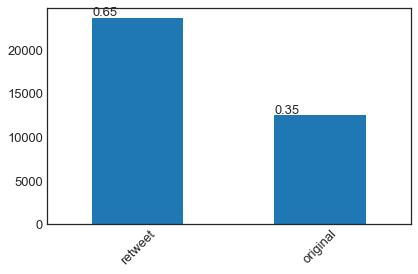

In [9]:
ax = df_cdc.tweet_type.value_counts().plot(kind='bar', rot=45)
for p in ax.patches:
    ax.annotate(str(round(p.get_height()/df_cdc.shape[0], 2)), (p.get_x() * 1, p.get_height() * 1.01))
plt.tight_layout()
plt.show()

ax = df_cdc.tweet_type_2.value_counts().plot(kind='bar', rot=45)
for p in ax.patches:
    ax.annotate(str(round(p.get_height()/df_cdc.shape[0], 2)), (p.get_x() * 1, p.get_height() * 1.01))
plt.tight_layout()
plt.show()

In [10]:
df_cdc.columns

Index(['date_only', 'favorite_count', 'hashtags', 'id',
       'in_reply_to_screen_name', 'in_reply_to_status_id',
       'in_reply_to_user_id', 'publish_date', 'retweet_count',
       'retweet_or_quote_id', 'retweet_or_quote_screen_name',
       'retweet_or_quote_user_id', 'sent_comp', 'text_mod', 'tweet_type',
       'tweet_type_2', 'tweet_url', 'urls', 'user_created_at',
       'user_followers_count', 'user_friends_count', 'user_id', 'user_name',
       'user_screen_name', 'user_statuses_count', 'user_verified',
       'datetime_EST', 'date_EST'],
      dtype='object')

In [11]:
df_cdc.head()

,date_only,favorite_count,hashtags,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,publish_date,retweet_count,retweet_or_quote_id,...,user_created_at,user_followers_count,user_friends_count,user_id,user_name,user_screen_name,user_statuses_count,user_verified,datetime_EST,date_EST
0,2020-01-22 00:00:00,1,NaN,1219819938468155392,NaN,NaN,NaN,2020-01-22 03:11:51,0,1.219773e+18,...,Tue Apr 03 22:10:54 +0000 2012,130,468,544714500,Tink 💿(Gwth's Girl) TinkerPixie,PixieWings76,3144,False,2020-01-21 22:11:51-05:00,2020-01-21
1,2020-01-22 00:00:00,0,NaN,1219855944906993664,NaN,NaN,NaN,2020-01-22 05:34:55,0,NaN,...,Tue Mar 04 05:41:22 +0000 2008,2006,4963,14076534,jmarine,jmarine,46388,False,2020-01-22 00:34:55-05:00,2020-01-22
2,2020-01-22 00:00:00,5,NaN,1219906716063670274,ThomasKlineMD,1.219797e+18,2.895908e+09,2020-01-22 08:56:40,0,NaN,...,Wed Aug 05 20:19:48 +0000 2009,140,190,63243885,NNNNNNNNNNNNN,sweet_revenge3,40879,False,2020-01-22 03:56:40-05:00,2020-01-22
3,2020-01-22 00:00:00,1,NaN,1219950051868454912,DeloarDuda,1.219950e+18,5.479425e+07,2020-01-22 11:48:52,0,NaN,...,Sun Apr 11 14:24:07 +0000 2010,1226,1574,131845620,Popsy Kanagaratnam,PKanagaratnam,254059,False,2020-01-22 06:48:52-05:00,2020-01-22
4,2020-01-22 00:00:00,1,NaN,1219953367503556608,SariArhoHavren,1.219951e+18,1.135341e+09,2020-01-22 12:02:03,0,NaN,...,Wed Mar 18 00:44:01 +0000 2009,1347,2222,24993262,Thomas//孔天慧,takiwatanga,7709,False,2020-01-22 07:02:03-05:00,2020-01-22


### Removing neutrals

In [12]:
# pd.set_option('display.max_colwidth', -1)
df_cdc_filtered = df_cdc[(df_cdc.sent_comp > 0.05) | (df_cdc.sent_comp < -0.05)]
print(df_cdc_filtered.shape)
df_cdc_filtered.to_csv(FILTER_DIR + "cdc_mask_neutrals_removed.csv", index=False)

num_removed = df_cdc.shape[0] - df_cdc_filtered.shape[0]
print('number of neutrals removed: ', num_removed)
print('fraction of tweets removed: ', num_removed/df_cdc.shape[0])

(26765, 28)
number of neutrals removed:  9403
fraction of tweets removed:  0.25998119884981197


In [13]:
# pd.set_option('display.max_colwidth', -1)
df_cdc_positive = df_cdc[df_cdc.sent_comp > 0.05]
print(df_cdc_positive.shape)

print('number of positives: ', df_cdc_positive.shape[0])
print('fraction of tweets that are positive: ', df_cdc_positive.shape[0]/df_cdc.shape[0])

(16754, 28)
number of positives:  16754
fraction of tweets that are positive:  0.4632271621322716


In [14]:
# pd.set_option('display.max_colwidth', -1)
df_cdc_negative = df_cdc[df_cdc.sent_comp < -0.05]
print(df_cdc_negative.shape)

print('number of negative: ', df_cdc_negative.shape[0])
print('fraction of tweets that are negative: ', df_cdc_negative.shape[0]/df_cdc.shape[0])

(10011, 28)
number of negative:  10011
fraction of tweets that are negative:  0.27679163901791637


# 1. CDC Plots

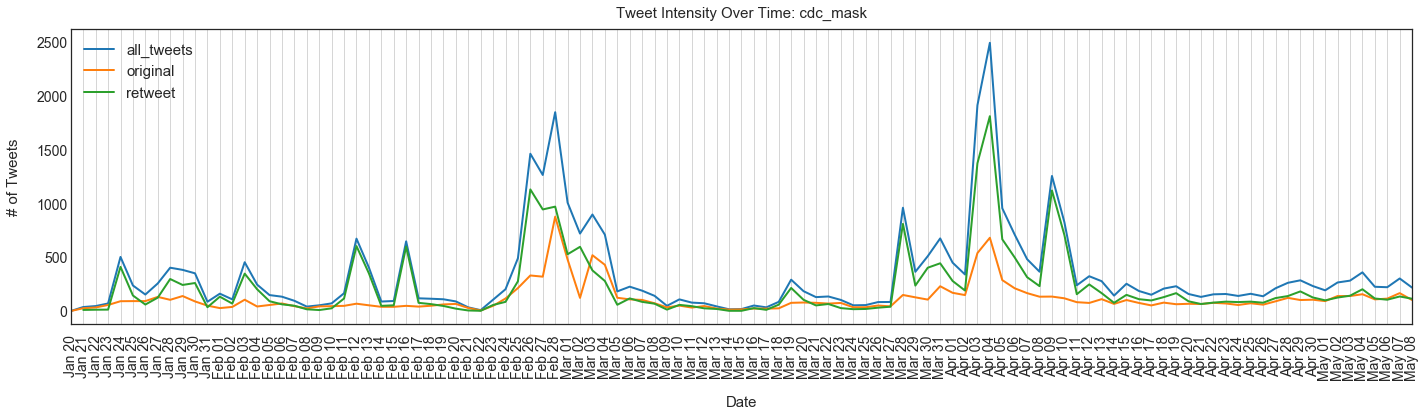

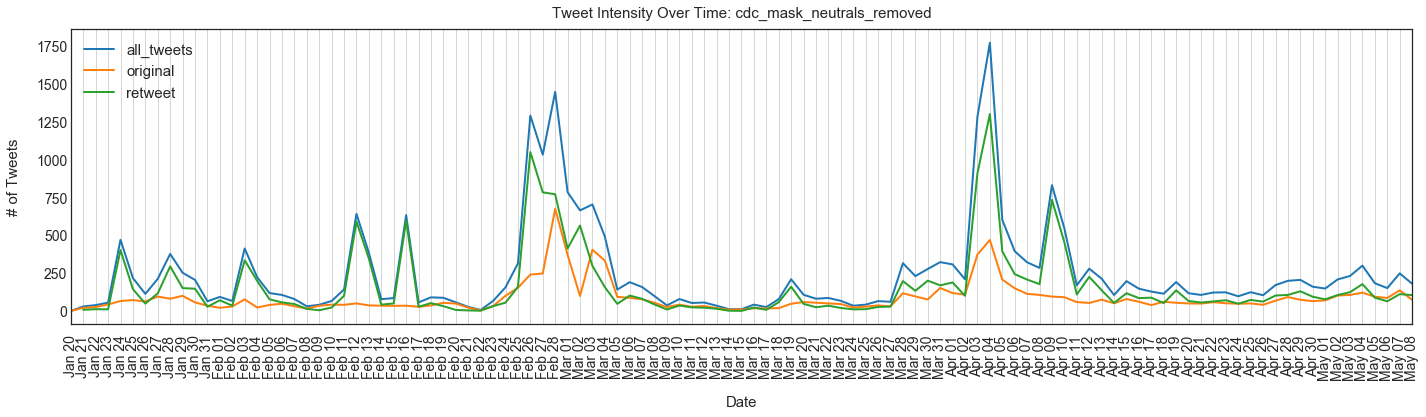

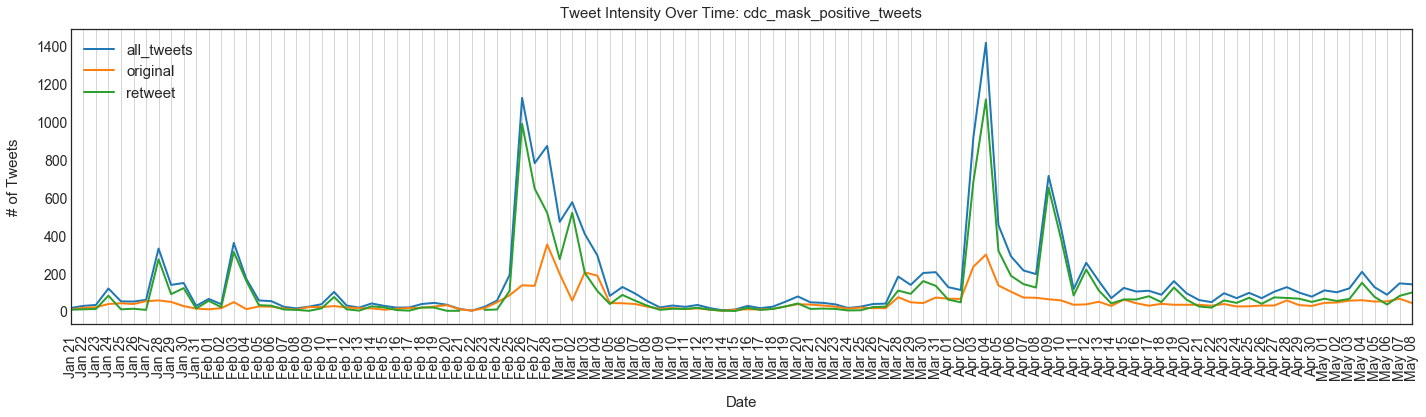

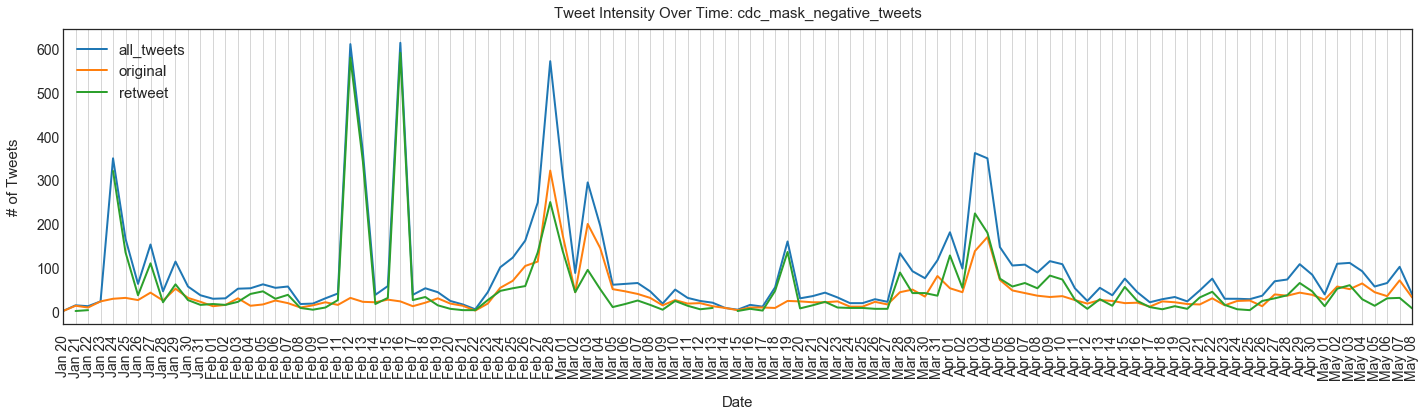

In [16]:
intensity_plots(df_cdc, 'date_EST', 'tweet_type_2', 'cdc_mask')
intensity_plots(df_cdc_filtered, 'date_EST', 'tweet_type_2', 'cdc_mask_neutrals_removed')
intensity_plots(df_cdc_positive, 'date_EST', 'tweet_type_2', 'cdc_mask_positive_tweets')
intensity_plots(df_cdc_negative, 'date_EST', 'tweet_type_2', 'cdc_mask_negative_tweets')

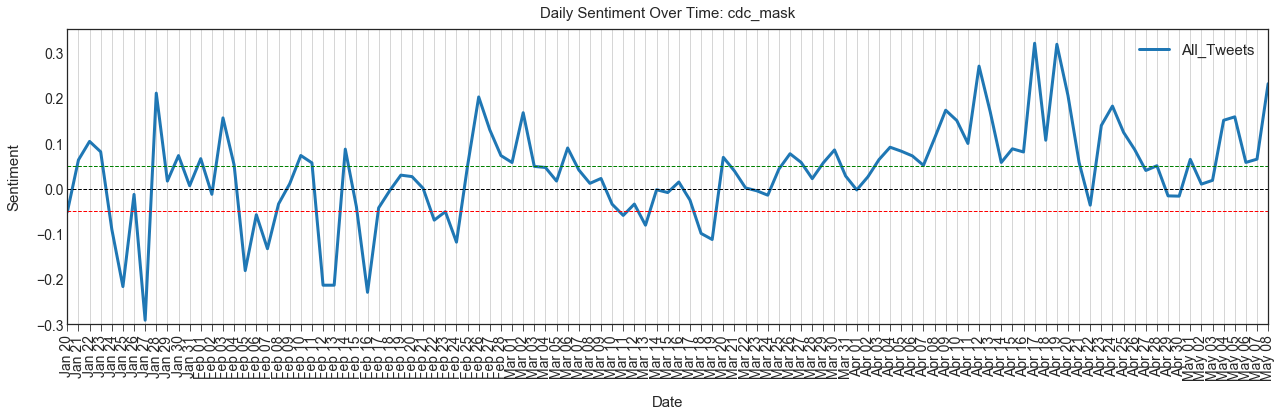

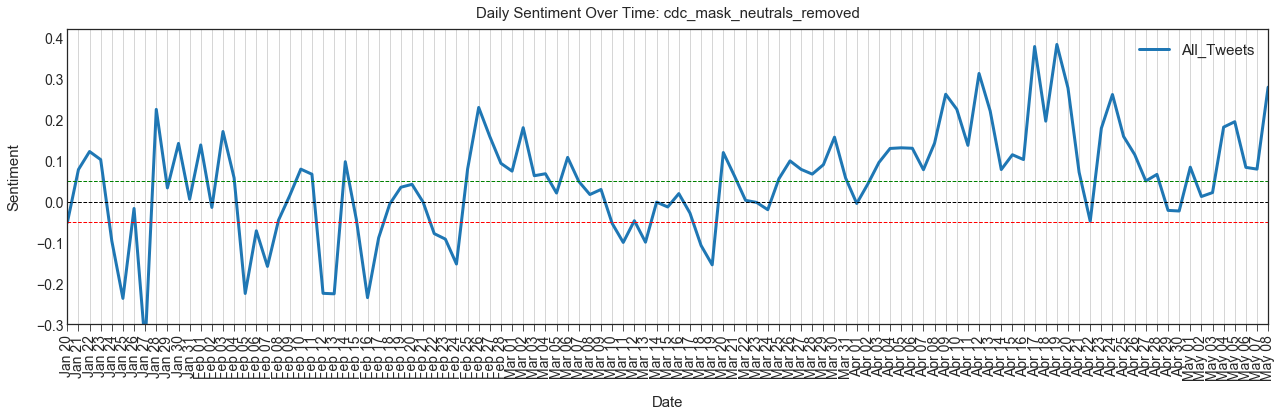

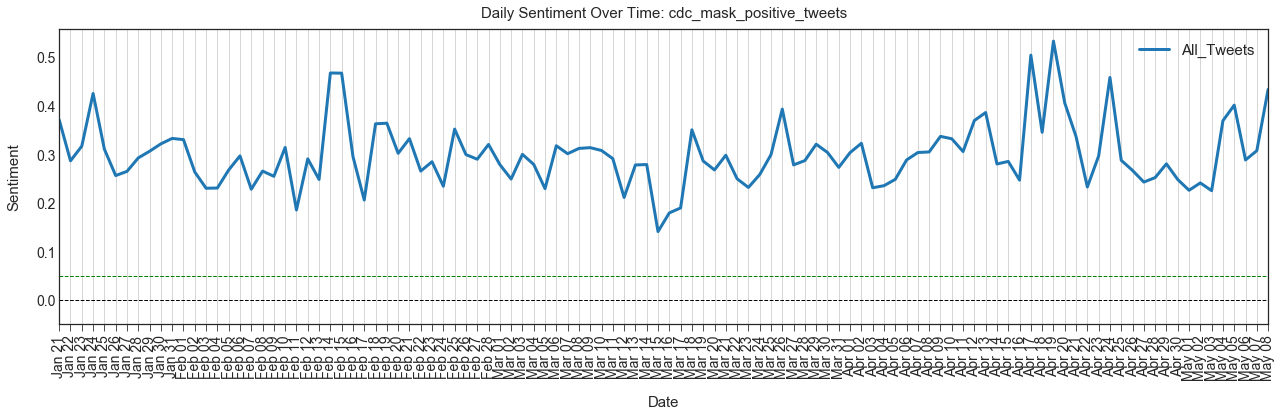

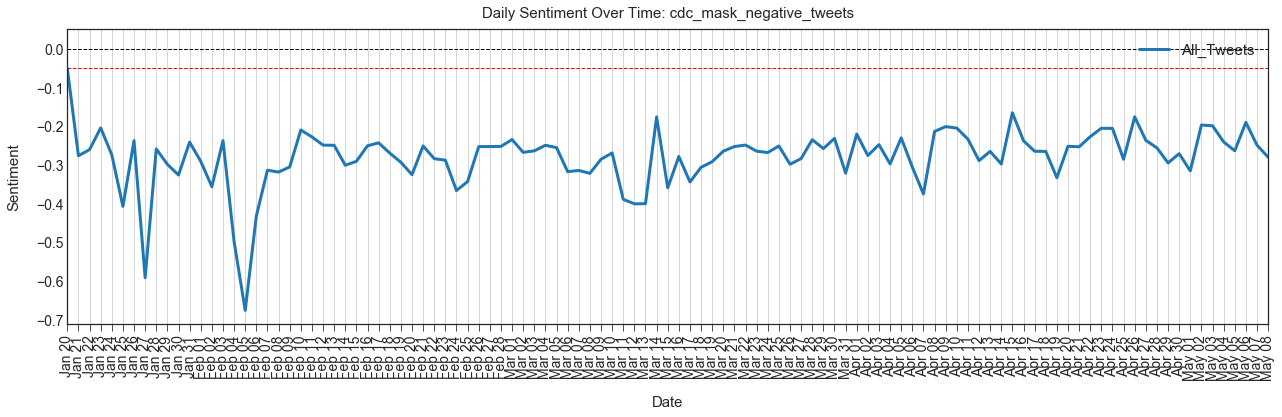

In [17]:
sentiment_plots(df_cdc, 'date_EST', 'tweet_type_2', 'cdc_mask')
sentiment_plots(df_cdc_filtered, 'date_EST', 'tweet_type_2', 'cdc_mask_neutrals_removed')
sentiment_plots(df_cdc_positive, 'date_EST', 'tweet_type_2', 'cdc_mask_positive_tweets')
sentiment_plots(df_cdc_negative, 'date_EST', 'tweet_type_2', 'cdc_mask_negative_tweets')

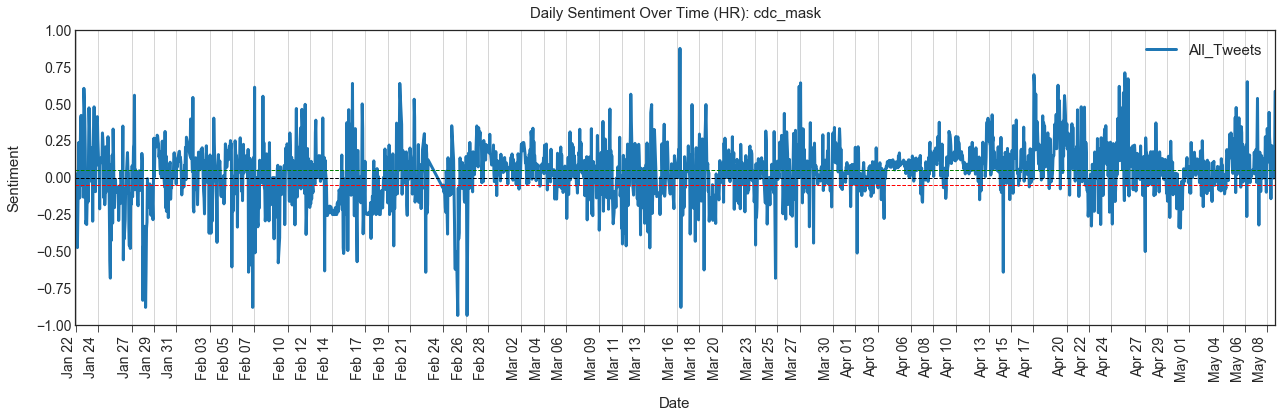

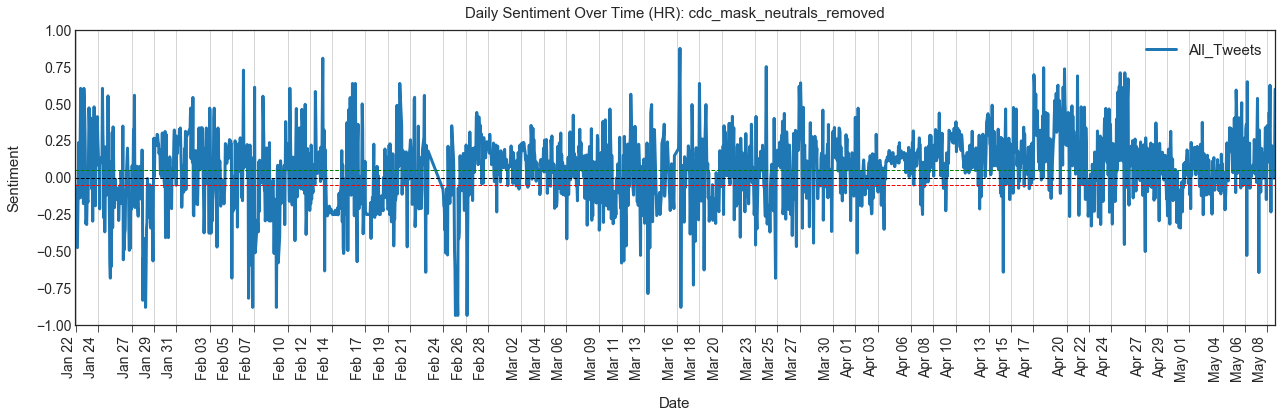

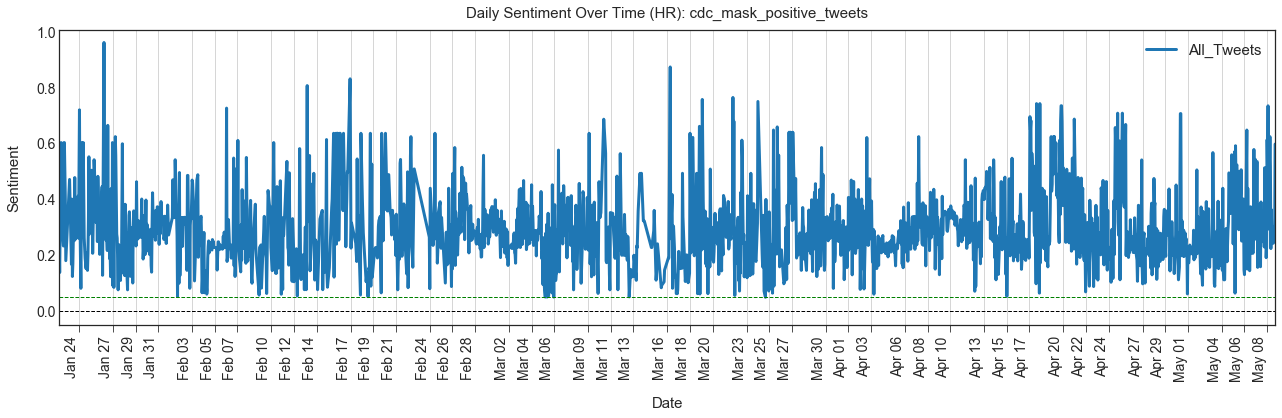

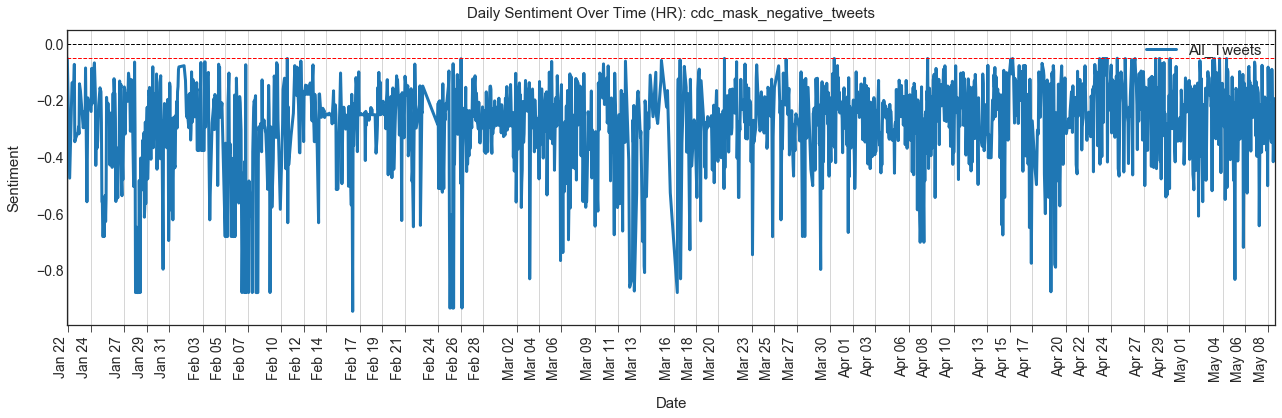

In [84]:
sentiment_plots(df_cdc, 'date_hr_EST_final', 'tweet_type_2', 'cdc_mask', timescale=True)
sentiment_plots(df_cdc_filtered, 'date_hr_EST_final', 'tweet_type_2', 'cdc_mask_neutrals_removed', timescale=True)
sentiment_plots(df_cdc_positive, 'date_hr_EST_final', 'tweet_type_2', 'cdc_mask_positive_tweets', timescale=True)
sentiment_plots(df_cdc_negative, 'date_hr_EST_final', 'tweet_type_2', 'cdc_mask_negative_tweets', timescale=True)

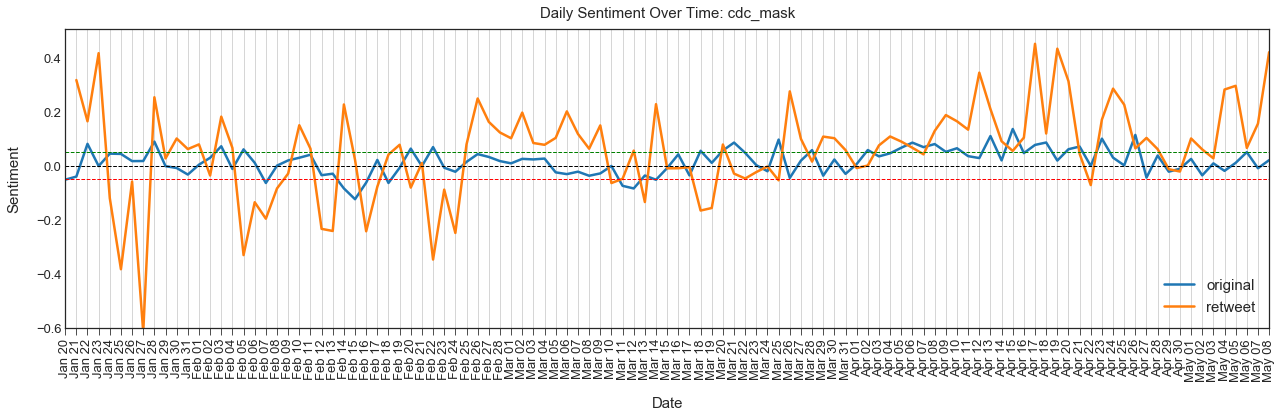

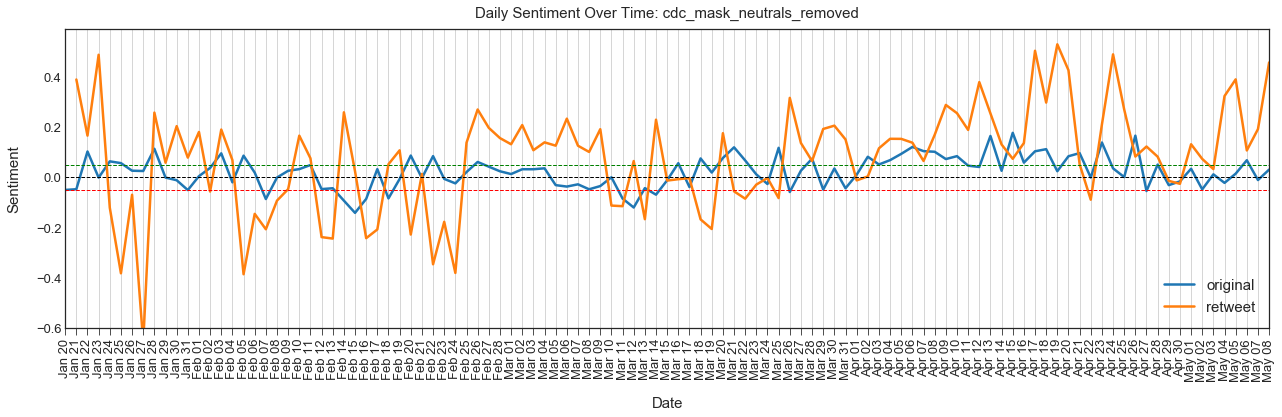

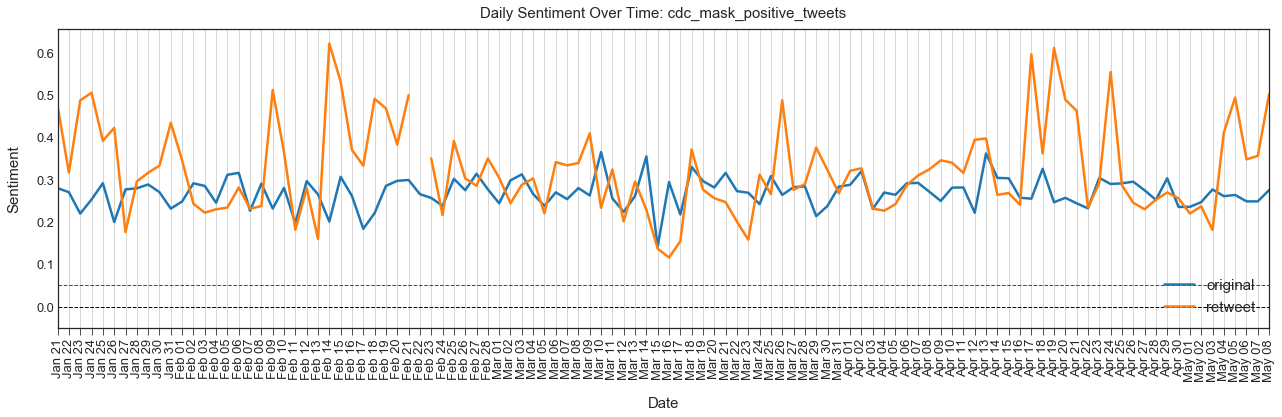

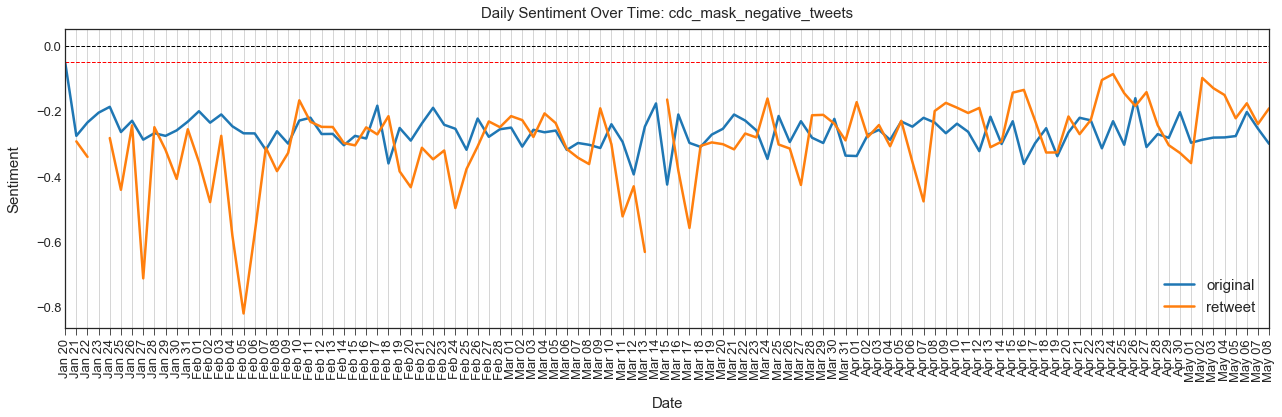

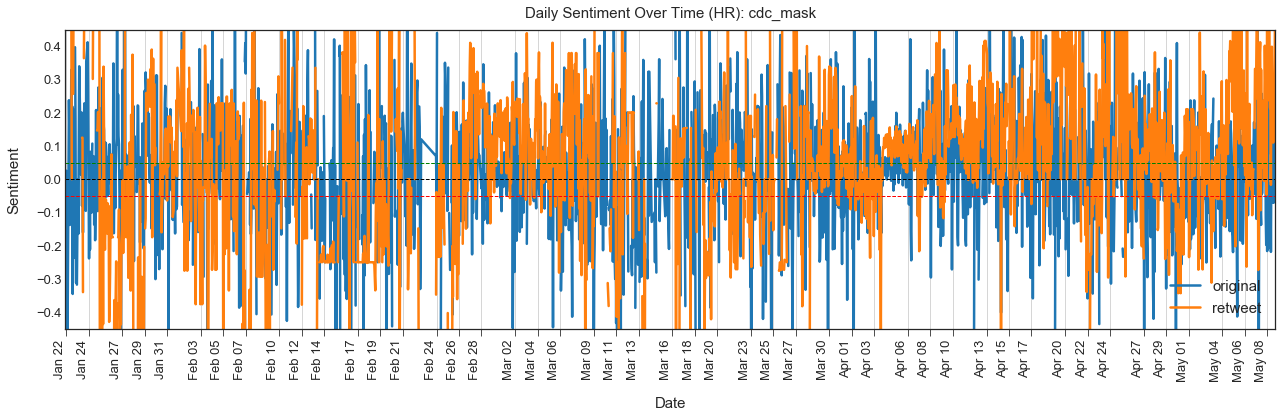

In [19]:
sentiment_plots_tweettype(df_cdc, 'date_EST', 'tweet_type_2', 'cdc_mask')
sentiment_plots_tweettype(df_cdc_filtered, 'date_EST', 'tweet_type_2', 'cdc_mask_neutrals_removed')
sentiment_plots_tweettype(df_cdc_positive, 'date_EST', 'tweet_type_2', 'cdc_mask_positive_tweets')
sentiment_plots_tweettype(df_cdc_negative, 'date_EST', 'tweet_type_2', 'cdc_mask_negative_tweets')



sentiment_plots_tweettype(df_cdc, 'date_hr_EST_final', 'tweet_type_2', 'cdc_mask', timescale=True)

# 2. Comparing CDC to other PHO's

In [17]:
df_cdc_intensity = pd.read_csv(INTENSITY_DIR + "cdc_mask_intensity_data.csv")
df_niaid_intensity = pd.read_csv(INTENSITY_DIR + "niaid_mask_intensity_data.csv")
df_nih_intensity = pd.read_csv(INTENSITY_DIR + "nih_mask_intensity_data.csv")
df_hhs_intensity = pd.read_csv(INTENSITY_DIR + "hhs_mask_intensity_data.csv")

pho_intensity_names = ['cdc', 'niaid', 'nih', 'hhs']
pho_intensity_list = [df_cdc_intensity, df_niaid_intensity, df_nih_intensity, df_hhs_intensity]
# get_shape(pho_intensity_list)


df_cdc_sentiment = pd.read_csv(SENTIMENT_DIR + "cdc_mask_sentiment_data.csv")
df_niaid_sentiment = pd.read_csv(SENTIMENT_DIR + "niaid_mask_sentiment_data.csv")
df_nih_sentiment = pd.read_csv(SENTIMENT_DIR + "nih_mask_sentiment_data.csv")
df_hhs_sentiment = pd.read_csv(SENTIMENT_DIR + "hhs_mask_sentiment_data.csv")

pho_sentiment_names = ['cdc', 'niaid', 'nih', 'hhs']
pho_sentiment_list = [df_cdc_sentiment, df_niaid_sentiment, df_nih_sentiment, df_hhs_sentiment]

In [18]:
df_pho_intensity = merge_dfs(pho_intensity_list)
df_pho_intensity.fillna(0,  inplace=True)
pho_intensity_cols = get_col_name(pho_intensity_names)
df_pho_intensity.columns = pho_intensity_cols
print(df_pho_intensity.shape)

df_pho_sentiment = merge_dfs(pho_sentiment_list)
df_pho_sentiment.fillna(0,  inplace=True)
df_pho_sentiment.columns = ['date_EST'] + pho_sentiment_names
print(df_pho_sentiment.shape)

(90, 13)
(90, 5)


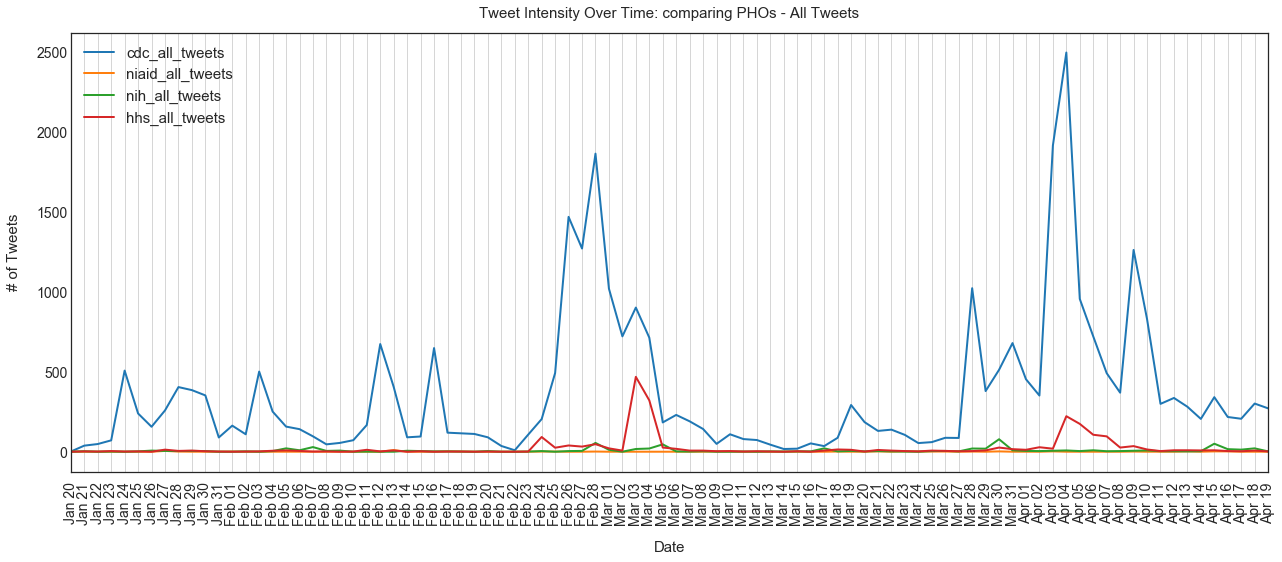

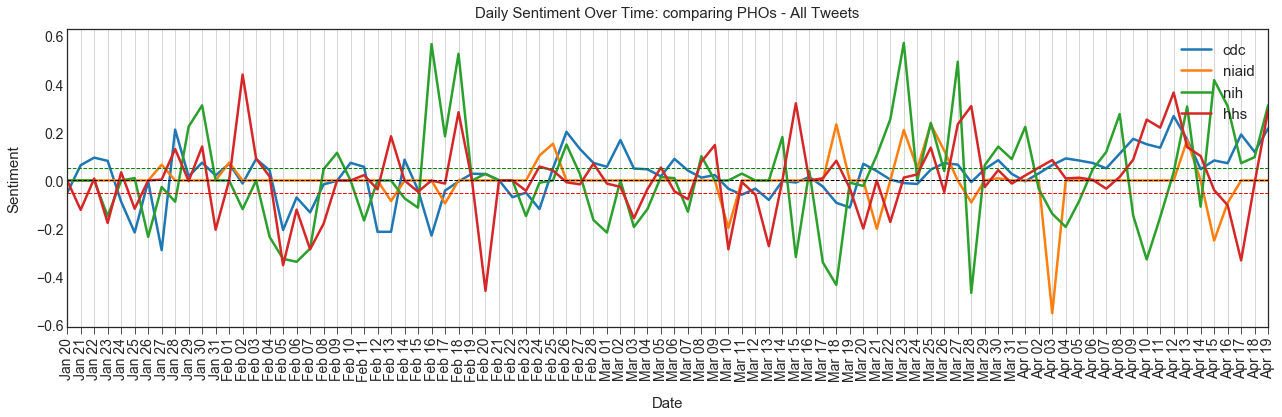

In [19]:
get_comparison_plot(df_pho_intensity, df_pho_sentiment, 'comparing PHOs - All Tweets')

# 3. Comparing all individuals

In [20]:
df_fauci_intensity = pd.read_csv(INTENSITY_DIR + "fauci_mask_intensity_data.csv")
df_collins_intensity = pd.read_csv(INTENSITY_DIR + "collins_mask_intensity_data.csv")
df_redfield_intensity = pd.read_csv(INTENSITY_DIR + "redfield_mask_intensity_data.csv")
df_azar_intensity = pd.read_csv(INTENSITY_DIR + "azar_mask_intensity_data.csv")
df_birx_intensity = pd.read_csv(INTENSITY_DIR + "birx_mask_intensity_data.csv")
df_surgeongeneral_intensity = pd.read_csv(INTENSITY_DIR + "surgeongeneral_mask_intensity_data.csv")
df_trump_intensity = pd.read_csv(INTENSITY_DIR + "trump_mask_intensity_data.csv")
df_pence_intensity = pd.read_csv(INTENSITY_DIR + "pence_mask_intensity_data.csv")
df_whitehouse_intensity = pd.read_csv(INTENSITY_DIR + "whitehouse_mask_intensity_data.csv")

names_intensity_names = ['fauci', 'collins', 'redfield', 'azar', 'birx', 'surgeongeneral', 'trump', 
                       'pence', 'whitehouse']
names_intensity_list = [df_fauci_intensity, df_collins_intensity, df_redfield_intensity, df_azar_intensity, 
                      df_birx_intensity, df_surgeongeneral_intensity, df_trump_intensity, df_pence_intensity, 
                      df_whitehouse_intensity]

df_fauci_sentiment = pd.read_csv(SENTIMENT_DIR + "fauci_mask_sentiment_data.csv")
df_collins_sentiment = pd.read_csv(SENTIMENT_DIR + "collins_mask_sentiment_data.csv")
df_redfield_sentiment = pd.read_csv(SENTIMENT_DIR + "redfield_mask_sentiment_data.csv")
df_azar_sentiment = pd.read_csv(SENTIMENT_DIR + "azar_mask_sentiment_data.csv")
df_birx_sentiment = pd.read_csv(SENTIMENT_DIR + "birx_mask_sentiment_data.csv")
df_surgeongeneral_sentiment = pd.read_csv(SENTIMENT_DIR + "surgeongeneral_mask_sentiment_data.csv")
df_trump_sentiment = pd.read_csv(SENTIMENT_DIR + "trump_mask_sentiment_data.csv")
df_pence_sentiment = pd.read_csv(SENTIMENT_DIR + "pence_mask_sentiment_data.csv")
df_whitehouse_sentiment = pd.read_csv(SENTIMENT_DIR + "whitehouse_mask_sentiment_data.csv")

names_sentiment_names = ['fauci', 'collins', 'redfield', 'azar', 'birx', 'surgeongeneral', 'trump', 
                       'pence', 'whitehouse']
names_sentiment_list = [df_fauci_sentiment, df_collins_sentiment, df_redfield_sentiment, df_azar_sentiment, 
                      df_birx_sentiment, df_surgeongeneral_sentiment, df_trump_sentiment, df_pence_sentiment, 
                      df_whitehouse_sentiment]

In [23]:
df_names_intensity = merge_dfs(names_intensity_list)
df_names_intensity.fillna(0,  inplace=True)
names_intensity_cols = get_col_name(names_intensity_names)
df_names_intensity.columns = names_intensity_cols
print(df_names_intensity.shape)

df_names_sentiment = merge_dfs(names_sentiment_list)
df_names_sentiment.fillna(0,  inplace=True)
df_names_sentiment.columns = ['date_EST'] + names_sentiment_names
print(df_names_sentiment.shape)

(54, 28)
(54, 10)


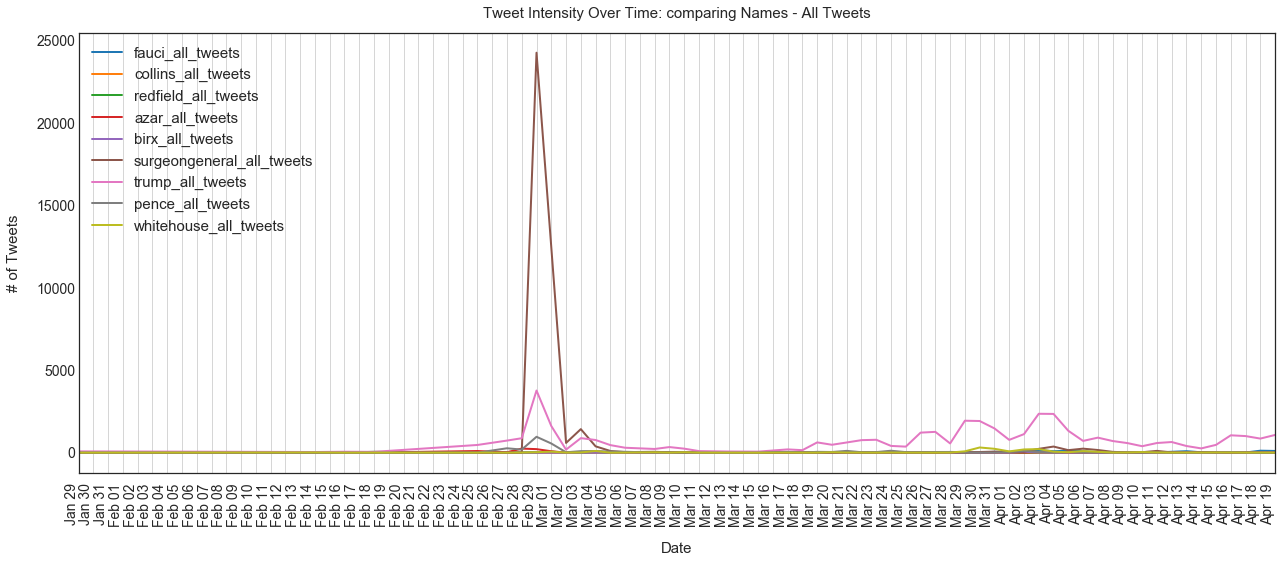

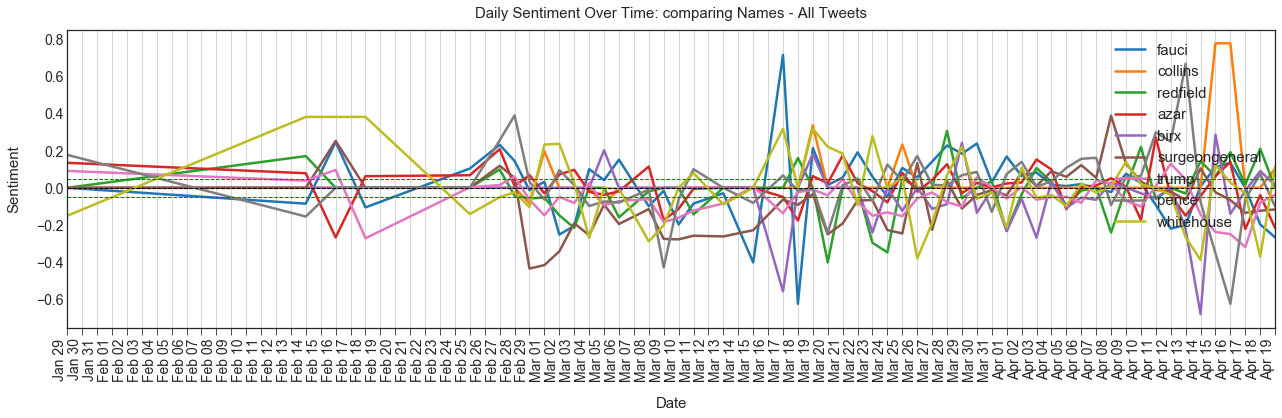

In [22]:
get_comparison_plot(df_names_intensity, df_names_sentiment, 'comparing Names - All Tweets')

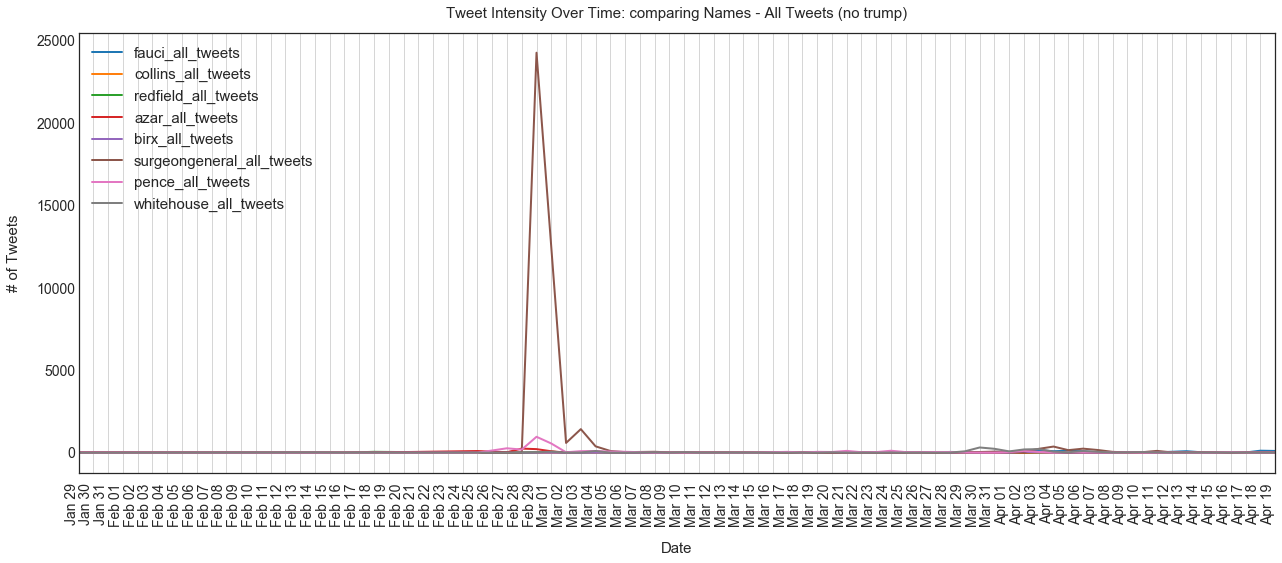

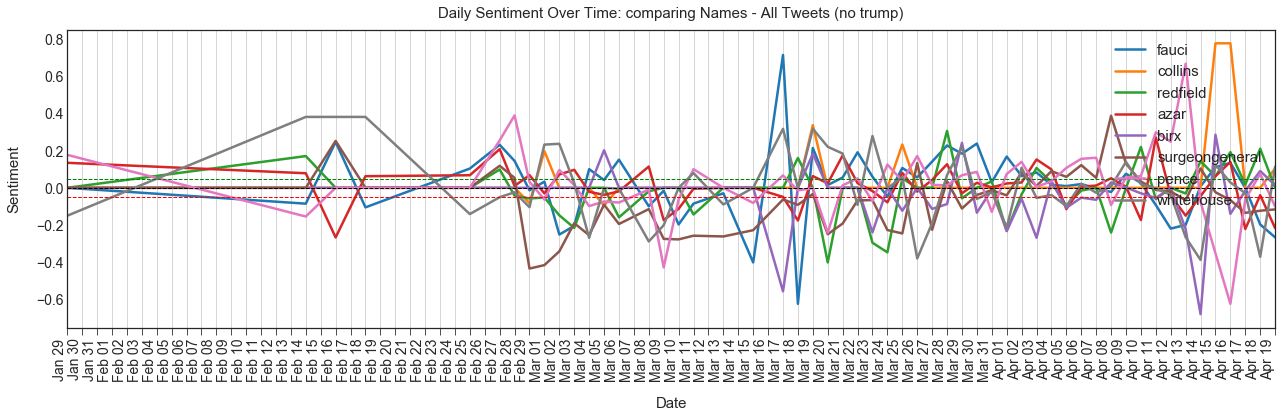

In [24]:
df_names_intensity.drop('trump_all_tweets', axis=1, inplace=True)
df_names_sentiment.drop('trump', axis=1, inplace=True)
get_comparison_plot(df_names_intensity, df_names_sentiment, 'comparing Names - All Tweets (no trump)')

# 4. Comparing (political) groupings

In [25]:
df_niaid_nih_intensity = pd.read_csv(INTENSITY_DIR + "niaid_nih_mask_intensity_data.csv")
df_niaid_nih_fauci_collins_intensity = pd.read_csv(INTENSITY_DIR + "niaid_nih_fauci_collins_mask_intensity_data.csv")
df_all_political_entities_intensity = pd.read_csv(INTENSITY_DIR + "all_political_entities_mask_intensity_data.csv")
df_political_health_entities_intensity = pd.read_csv(INTENSITY_DIR + "political_health_entities_mask_intensity_data.csv")

pol_intensity_names = ['niaid_nih', 'niaid_nih_fauci_collins', 'all_political_entities', 'political_health_entities']
pol_intensity_list = [df_niaid_nih_intensity, df_niaid_nih_fauci_collins_intensity, 
                      df_all_political_entities_intensity, df_political_health_entities_intensity]
# get_shape(pho_intensity_list)

df_niaid_nih_sentiment = pd.read_csv(SENTIMENT_DIR + "niaid_nih_mask_sentiment_data.csv")
df_niaid_nih_fauci_collins_sentiment = pd.read_csv(SENTIMENT_DIR + "niaid_nih_fauci_collins_mask_sentiment_data.csv")
df_all_political_entities_sentiment = pd.read_csv(SENTIMENT_DIR + "all_political_entities_mask_sentiment_data.csv")
df_political_health_entities_sentiment = pd.read_csv(SENTIMENT_DIR + "political_health_entities_mask_sentiment_data.csv")

pol_sentiment_names = ['niaid_nih', 'niaid_nih_fauci_collins', 'all_political_entities', 'political_health_entities']
pol_sentiment_list = [df_niaid_nih_sentiment, df_niaid_nih_fauci_collins_sentiment, 
                      df_all_political_entities_sentiment, df_political_health_entities_sentiment]

In [26]:
df_pol_intensity = merge_dfs(pol_intensity_list)
df_pol_intensity.fillna(0,  inplace=True)
pol_intensity_cols = get_col_name(pol_intensity_names)
df_pol_intensity.columns = pol_intensity_cols
print(df_pol_intensity.shape)

df_pol_sentiment = merge_dfs(pol_sentiment_list)
df_pol_sentiment.fillna(0,  inplace=True)
df_pol_sentiment.columns = ['date_EST'] + pol_sentiment_names
print(df_pol_sentiment.shape)

(78, 13)
(78, 5)


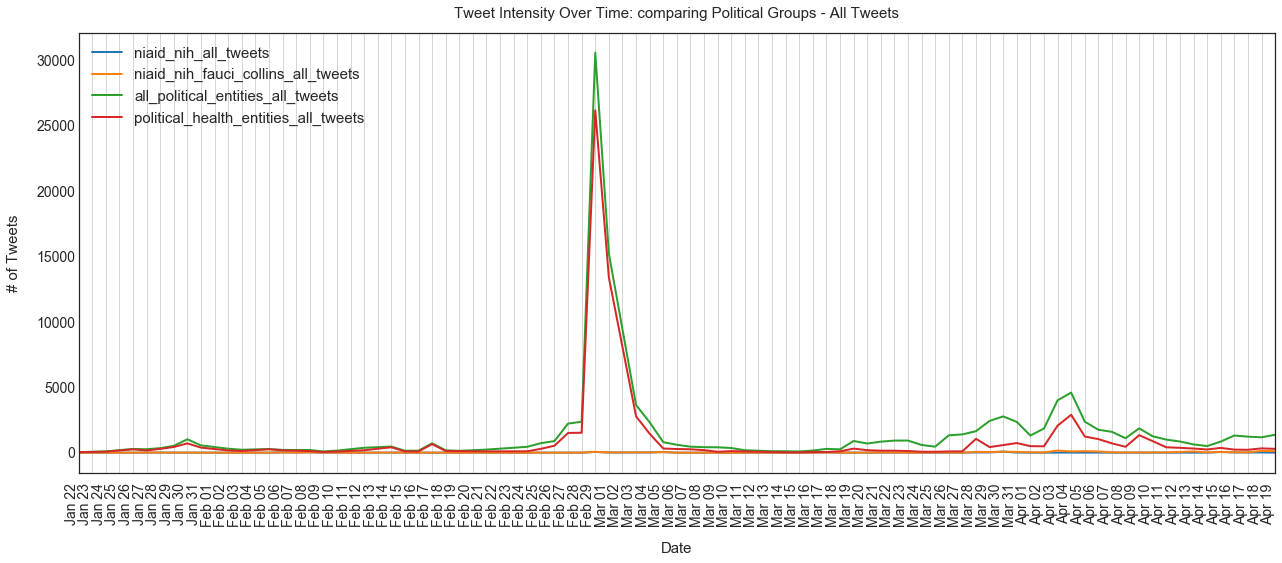

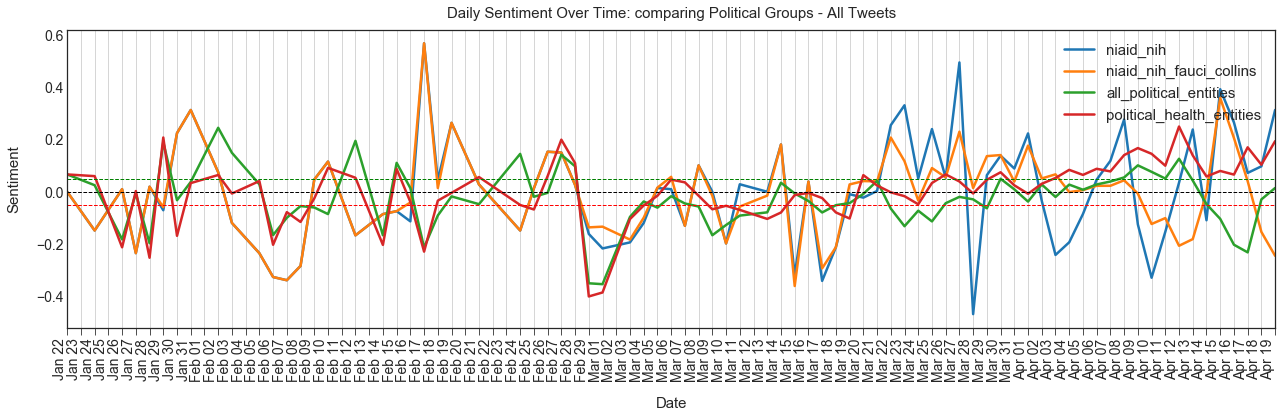

In [27]:
get_comparison_plot(df_pol_intensity, df_pol_sentiment, 'comparing Political Groups - All Tweets')

## END

## Sandbox

Sentiment Breakdown - What fraction of tweets are positive/negative/neutal?
negative    0.407350
neutral     0.306596
positive    0.286054
Name: sent_class, dtype: float64


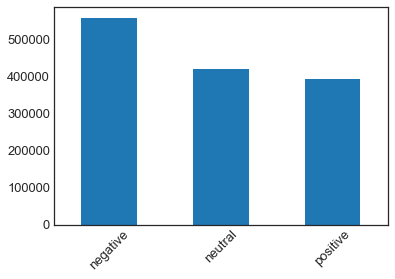

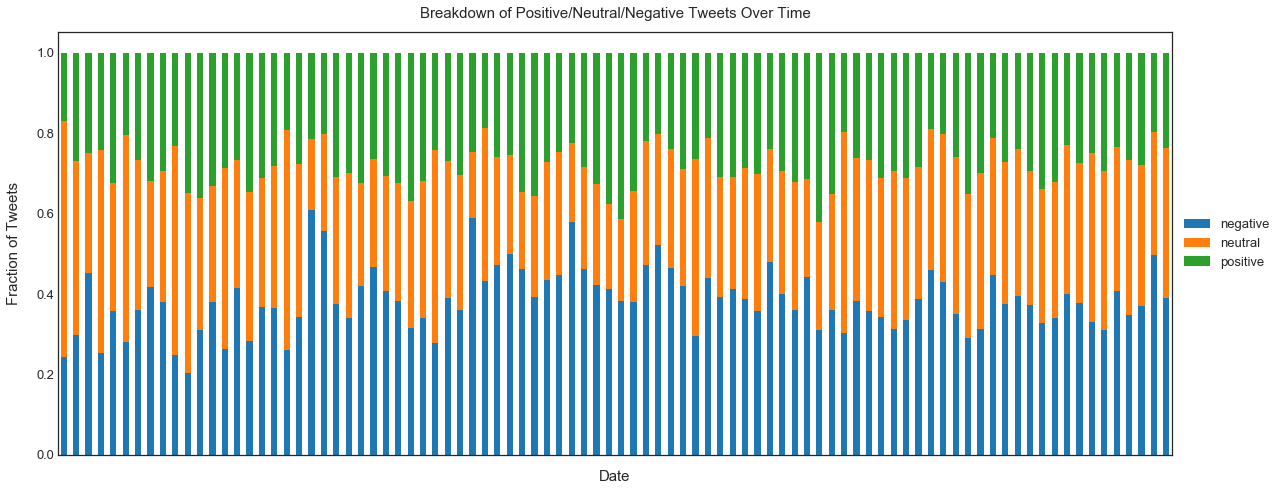

In [84]:
sentiment_polarity_plot(df_cdc, 'date_EST', 'tweet_type_2', 'cdc')